In [1]:
%pwd

'c:\\Users\\Fahmi Maulana\\Documents\\Projects\\weather-anomaly-detection\\exploratory-data-analysis\\notebooks'

In [2]:
%cd ../..

c:\Users\Fahmi Maulana\Documents\Projects\weather-anomaly-detection


c:\Users\Fahmi Maulana\.pyenv-win-venv\envs\weather-anomaly-detection\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
viz_dir = "visualizations/"

# Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tseries.transforms.stationary_utils import check_trend, check_seasonality
import statsmodels.api as sm

# Initial Data Inspection
## Loading Data

In [5]:
# Dictionary mapping weather codes to descriptions
weather_code_mapping = {
    0: "Clear Sky",
    1: "Mainly Clear",
    2: "Partly Cloudy",
    3: "Overcast",
    45: "Fog",
    48: "Depositing Rime Fog",
    51: "Drizzle: Light",
    53: "Drizzle: Moderate",
    55: "Drizzle: Dense",
    56: "Freezing Drizzle: Light",
    57: "Freezing Drizzle: Dense",
    61: "Rain: Slight",
    63: "Rain: Moderate",
    65: "Rain: Heavy",
    66: "Freezing Rain: Light",
    67: "Freezing Rain: Heavy",
    71: "Snow Fall: Slight",
    73: "Snow Fall: Moderate",
    75: "Snow Fall: Heavy",
    77: "Snow Grains",
    80: "Rain Showers: Slight",
    81: "Rain Showers: Moderate",
    82: "Rain Showers: Violent",
    85: "Snow Showers: Slight",
    86: "Snow Showers: Heavy",
    95: "Thunderstorm: Slight or Moderate",
    96: "Thunderstorm with Hail",
    99: "Thunderstorm with Hail"
}

In [6]:
pd.set_option("display.max_columns", None)
raw_df = pd.read_csv("./data/01_raw/jakarta_daily_weather_data_1980-2023.csv", 
                     date_parser=lambda x: pd.to_datetime(x).tz_convert('Asia/Bangkok'),
                     parse_dates=["datetime"],
                    )

daily_raw_df = raw_df.copy()
daily_raw_df["weather_description"] = daily_raw_df["weather_code"].map(weather_code_mapping)
daily_raw_df.rename(columns={"date":"datetime"}, inplace=True)
daily_raw_df["date"] = daily_raw_df["datetime"].dt.date
daily_raw_df["year"] = daily_raw_df["datetime"].dt.year
daily_raw_df["month"] = daily_raw_df.set_index("datetime").index.strftime('%B')
daily_raw_df


C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_33640\122731996.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  raw_df = pd.read_csv("./data/01_raw/jakarta_daily_weather_data_1980-2023.csv",


datetime  weather_code  temperature_2m_max  \
0     1980-01-01 00:00:00+07:00          63.0           28.846000   
1     1980-01-02 00:00:00+07:00          63.0           27.346000   
2     1980-01-03 00:00:00+07:00          63.0           28.146000   
3     1980-01-04 00:00:00+07:00          61.0           28.546000   
4     1980-01-05 00:00:00+07:00          63.0           28.946000   
...                         ...           ...                 ...   
16066 2023-12-27 00:00:00+07:00          61.0           30.765501   
16067 2023-12-28 00:00:00+07:00          63.0           32.015500   
16068 2023-12-29 00:00:00+07:00          63.0           30.915500   
16069 2023-12-30 00:00:00+07:00          63.0           30.815500   
16070 2023-12-31 00:00:00+07:00          65.0           30.915500   

       temperature_2m_min  temperature_2m_mean  apparent_temperature_max  \
0               24.046000            25.854330                 34.134132   
1               24.046000            25.212667                 31.262905   
2               23.346000            25.237665                 32.756325   
3               22.696000            25.487669                 34.630340   
4               22.896000            25.787668                 35.127403   
...                   ...                  ...                       ...   
16066           24.715500            27.171751                 37.685635   
16067           24.315500            27.400917                 38.291550   
16068           24.965500            27.521751                 38.060226   
16069           24.065500            26.984251                 38.101635   
16070           24.865501            26.921753                 37.692158   

       apparent_temperature_min  apparent_temperature_mean  sunrise  sunset  \
0                     27.530203                  29.699210        0       0   
1                     27.693266                  29.115060        0       0   
2                     27.296764                  29.595587        0       0   
3                     26.811935                  30.100534        0       0   
4                     26.726374                  29.990640        0       0   
...                         ...                        ...      ...     ...   
16066                 29.997322                  32.890606        0       0   
16067                 29.685040                  33.214333        0       0   
16068                 30.560104                  33.526210        0       0   
16069                 28.255577                  32.431828        0       0   
16070                 29.641083                  32.717373        0       0   

       daylight_duration  sunshine_duration  precipitation_sum   rain_sum  \
0              44900.156          33576.977           6.300000   6.300000   
1              44895.168          22360.742           9.600000   9.600000   
2              44889.720          27455.455          10.900001  10.900001   
3              44883.800          38627.418           8.100000   8.100000   
4              44877.360          42273.070           8.999999   8.999999   
...                  ...                ...                ...        ...   
16066          44917.934          39061.520           5.800000   5.800000   
16067          44915.016          42071.566           9.500000   9.500000   
16068          44911.582          35891.555           8.100000   8.100000   
16069          44907.640          39464.184          18.500000  18.500000   
16070          44903.200          33780.492          21.300001  21.300001   

       snowfall_sum  precipitation_hours  wind_speed_10m_max  \
0               0.0                  5.0           15.256526   
1               0.0                 16.0           14.003029   
2               0.0                 15.0           11.525623   
3               0.0                 17.0           12.229406   
4               0.0                  4.0           14.044615   
...             ...    

## Check Data Types

In [7]:
daily_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16071 entries, 0 to 16070
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype                       
---  ------                       --------------  -----                       
 0   datetime                     16071 non-null  datetime64[ns, Asia/Bangkok]
 1   weather_code                 16071 non-null  float64                     
 2   temperature_2m_max           16071 non-null  float64                     
 3   temperature_2m_min           16071 non-null  float64                     
 4   temperature_2m_mean          16071 non-null  float64                     
 5   apparent_temperature_max     16071 non-null  float64                     
 6   apparent_temperature_min     16071 non-null  float64                     
 7   apparent_temperature_mean    16071 non-null  float64                     
 8   sunrise                      16071 non-null  int64                       
 9   sunset           

## Check Missing Values

In [8]:
daily_raw_df.isnull().sum()

datetime                       0
weather_code                   0
temperature_2m_max             0
temperature_2m_min             0
temperature_2m_mean            0
apparent_temperature_max       0
apparent_temperature_min       0
apparent_temperature_mean      0
sunrise                        0
sunset                         0
daylight_duration              0
sunshine_duration              0
precipitation_sum              0
rain_sum                       0
snowfall_sum                   0
precipitation_hours            0
wind_speed_10m_max             0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
shortwave_radiation_sum        0
et0_fao_evapotranspiration     0
weather_description            0
date                           0
year                           0
month                          0
dtype: int64

In [9]:
# Create a complete date range from 2010-01-01 to 2023-12-31
date_range = pd.date_range(start='1980-01-01', end='2023-12-31')

# Identify missing dates by comparing the date range with the dates in the dataset
missing_dates = date_range.difference(daily_raw_df['date'])
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

## Descriptive Statistics

In [10]:
daily_raw_df.describe().T

count          mean          std           min  \
weather_code                 16071.0     50.185489    19.507805      0.000000   
temperature_2m_max           16071.0     29.667940     1.345837     24.396000   
temperature_2m_min           16071.0     23.478697     0.738178     18.946000   
temperature_2m_mean          16071.0     26.246254     0.819986     23.568914   
apparent_temperature_max     16071.0     35.071158     1.792693     27.294989   
apparent_temperature_min     16071.0     27.829953     1.141683     20.394630   
apparent_temperature_mean    16071.0     30.929537     1.090409     26.212214   
sunrise                      16071.0      0.000000     0.000000      0.000000   
sunset                       16071.0      0.000000     0.000000      0.000000   
daylight_duration            16071.0  43599.601534   888.808748  42353.152000   
sunshine_duration            16071.0  35117.350641  8278.327651      0.000000   
precipitation_sum            16071.0      5.627640     6.900759      0.000000   
rain_sum                     16071.0      5.627640     6.900759      0.000000   
snowfall_sum                 16071.0      0.000000     0.000000      0.000000   
precipitation_hours          16071.0      8.169187     6.379450      0.000000   
wind_speed_10m_max           16071.0     12.100508     3.521915      4.394360   
wind_gusts_10m_max           16071.0     27.580489     7.034185     11.520000   
wind_direction_10m_dominant  16071.0    172.963715    99.126157      0.000019   
shortwave_radiation_sum      16071.0     18.741772     3.752171      2.540000   
et0_fao_evapotranspiration   16071.0      3.857749     0.812489      0.760922   
year                         16071.0   2001.498973    12.698847   1980.000000   

                                      25%           50%           75%  \
weather_code                    51.000000     55.000000     61.000000   
temperature_2m_max              28.846000     29.646000     30.496000   
temperature_2m_min              23.046000     23.496000     23.946000   
temperature_2m_mean             25.685585     26.202250     26.785583   
apparent_temperature_max        34.043019     35.279545     36.327717   
apparent_temperature_min        27.151536     27.843140     28.548918   
apparent_temperature_mean       30.249876     30.987549     31.671599   
sunrise                          0.000000      0.000000      0.000000   
sunset                           0.000000      0.000000      0.000000   
daylight_duration            42730.258000  43564.445000  44464.984000   
sunshine_duration            34070.271000  38577.992000  39893.472500   
precipitation_sum                0.600000      3.400000      8.400000   
rain_sum                         0.600000      3.400000      8.400000   
snowfall_sum                     0.000000      0.000000      0.000000   
precipitation_hours              3.000000      7.000000     12.000000   
wind_speed_10m_max               9.422101     11.609651     14.332340   
wind_gusts_10m_max              22.319998     26.280000     31.319998   
wind_direction_10m_dominant     84.510757    164.357700    261.462310   
shortwave_radiation_sum         16.860000     19.310000     21.280000   
et0_fao_evapotranspiration       3.395977      3.911564      4.385050   
year                          1990.500000   2001.000000   2012.000000   

                                      max  
weather_code                    65.000000  
temperature_2m_max              35.065502  
temperature_2m_min              26.315500  
temperature_2m_mean             29.384254  
apparent_temperature_max        39.983460  
apparent_temperature_min        31.695213  
apparent_temperature_mean       34.238796  
sunrise                          0.000000  
sunset                           0.000000  
daylight_duration            44924.848000  
sunshine_duration            42305.290000  
precipitation_sum              150.400010  
rain_sum                       150.400010  
snowfall_sum             

# Initial Visualizations
## Daily Precipitation Plot

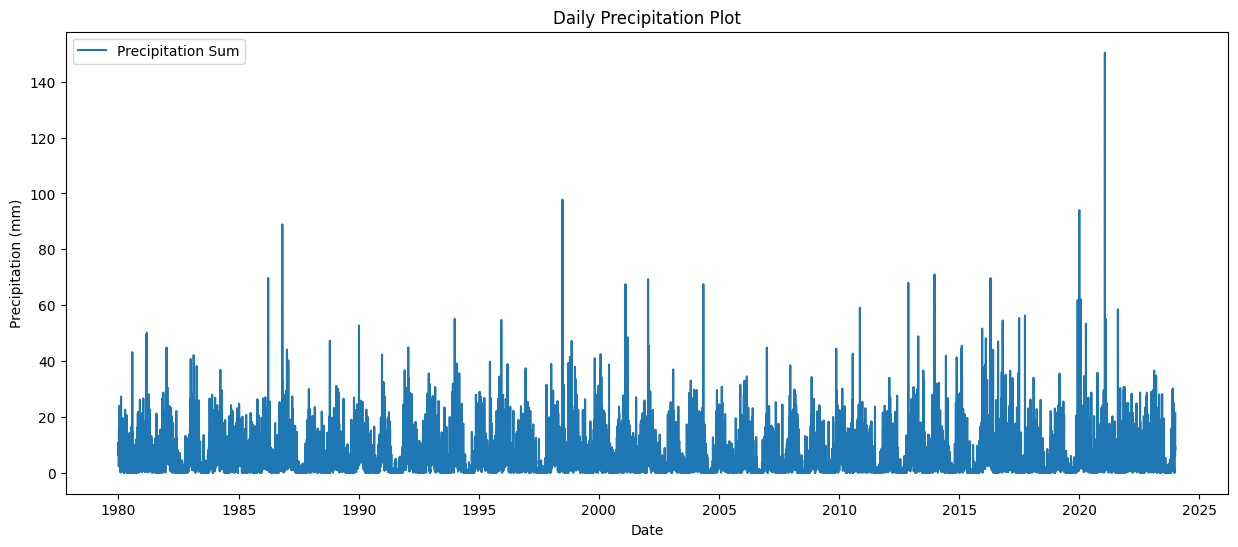

In [11]:
# Time series plot of precipitation_sum
plt.figure(figsize=(15, 6))
plt.plot(daily_raw_df['date'], daily_raw_df['precipitation_sum'], label='Precipitation Sum')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Daily Precipitation Plot')
plt.legend()
plt.show()

In [12]:
# Calculate the moving average (e.g., 365-day window for yearly trend)
daily_raw_df['moving_average'] = daily_raw_df['precipitation_sum'].rolling(window=365).mean()

# Convert dates to numerical values for LOWESS
daily_raw_df['date_numeric'] = daily_raw_df['datetime'].map(pd.Timestamp.toordinal)

# Perform LOWESS smoothing
lowess_smoothed = sm.nonparametric.lowess(daily_raw_df['precipitation_sum'], daily_raw_df['date_numeric'], frac=0.02)
lowess_df = pd.DataFrame(lowess_smoothed, columns=['date_numeric', 'lowess'])
lowess_df['date'] = lowess_df['date_numeric'].round().astype(int).map(pd.Timestamp.fromordinal)

# Plot
fig = go.Figure()

# Add the original precipitation sum time series
fig.add_trace(go.Scatter(x=daily_raw_df['date'], y=daily_raw_df['precipitation_sum'],
                         mode='lines', name='Precipitation Sum'))

# Add the moving average line
fig.add_trace(go.Scatter(x=daily_raw_df['date'], y=daily_raw_df['moving_average'],
                         mode='lines', name='Moving Average'))

# Add the LOWESS smoothed line
fig.add_trace(go.Scatter(x=lowess_df['date'], y=lowess_df['lowess'],
                         mode='lines', name='LOWESS'))

# Update layout
title = 'Daily Precipitation in Jakarta from 1980-2023'
fig.update_layout(title= title,
                  xaxis_title='Date',
                  yaxis_title='Precipitation (mm)',
                  height=600,
                  width=1000,
                  title_x=0.5)

# Add range slider
fig.update_xaxes(rangeslider_visible=True)

# Show the figure
# fig.write_image(viz_dir + f"{title}.jpeg")
fig.show()

## Daily Precipitation Distribution Plot

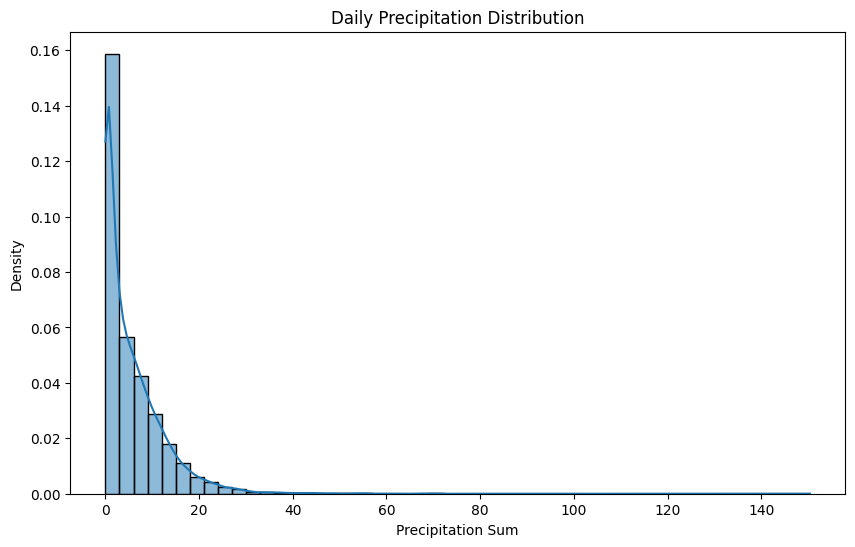

In [13]:
# Distribution plot of precipitation_sum
plt.figure(figsize=(10, 6))
sns.histplot(raw_df['precipitation_sum'], bins=50, kde=True, stat="density")
plt.xlabel('Precipitation Sum')
plt.title('Daily Precipitation Distribution')
plt.show()

In [14]:
fig = px.histogram(daily_raw_df, x="precipitation_sum",
                   marginal="box", # or violin, rug
                   hover_data=daily_raw_df[["precipitation_sum"]].columns)

# Update layout
title = 'Daily Precipitation Distribution in Jakarta'
fig.update_layout(title= title,
                  height=600,
                  width=1000,
                  title_x=0.5)

# fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Box Plot

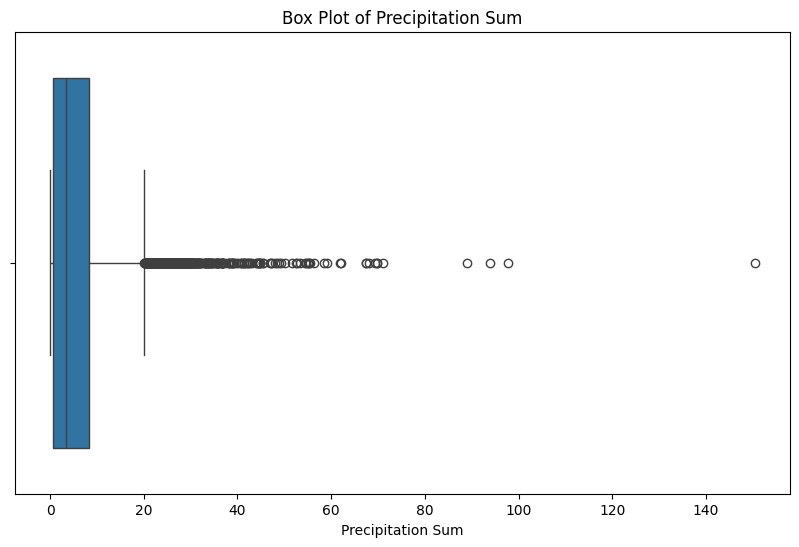

In [15]:
# Box plot to identify outliers in precipitation_sum
plt.figure(figsize=(10, 6))
sns.boxplot(x=daily_raw_df['precipitation_sum'])
plt.xlabel('Precipitation Sum')
plt.title('Box Plot of Precipitation Sum')
plt.show()

# Trend and Seasonality Analysis
## Decompose Time Series

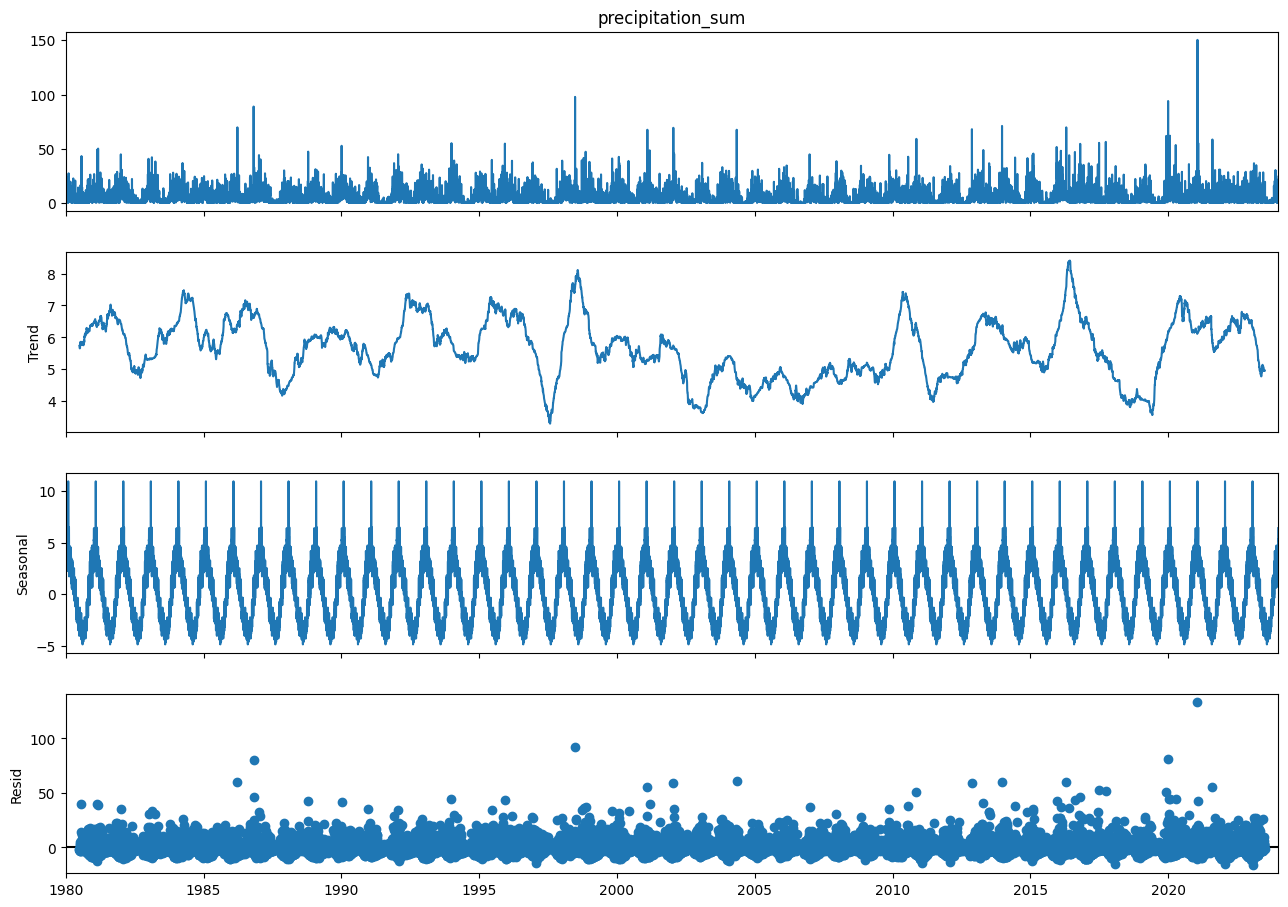

In [16]:
# Seasonal decomposition of time series data
decomposition = seasonal_decompose(daily_raw_df.set_index('date')['precipitation_sum'], model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

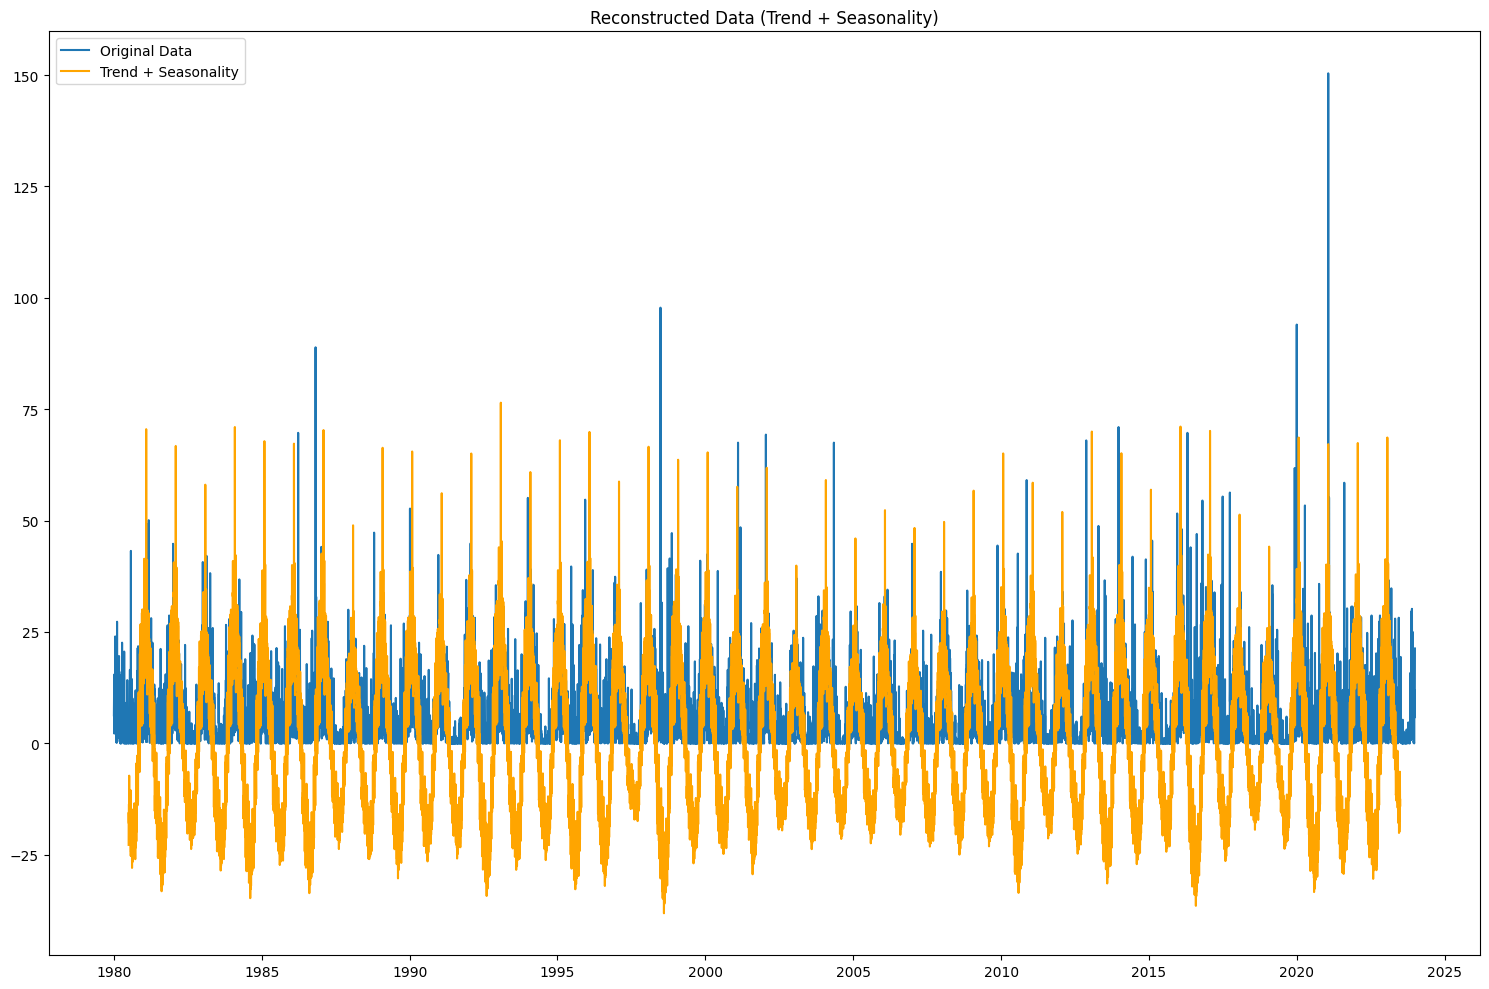

In [17]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

reconstructed = trend * seasonal

# Plot perbandingan antara data asli dengan hasil dekomposisi
plt.figure(figsize=(15, 10))

plt.plot(daily_raw_df.set_index('date')['precipitation_sum'], label='Original Data')
plt.plot(reconstructed, label='Trend + Seasonality', color='orange')
plt.title('Original Data')
plt.title('Reconstructed Data (Trend + Seasonality)')
plt.legend()

plt.tight_layout()
plt.show()

## Check Trend and Seasonality

In [18]:
kendall_tau_res = check_trend(daily_raw_df.set_index('date')['precipitation_sum'], confidence=0.05)
mann_kendall_res = check_trend(daily_raw_df.set_index('date')['precipitation_sum'], confidence=0.05, mann_kendall=True)
mann_kendall_seas_res = check_trend(daily_raw_df.set_index('date')['precipitation_sum'], confidence=0.05, mann_kendall=True, seasonal_period=None)
print(f"Kendalls Tau: Trend: {kendall_tau_res.trend} | Direction: {kendall_tau_res.direction} | Deterministic: {kendall_tau_res.deterministic}")
print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} | Deterministic: {mann_kendall_res.deterministic}")
print(f"Mann-Kendalls Seasonal: Trend: {mann_kendall_seas_res.trend} | Direction: {mann_kendall_seas_res.direction} | Deterministic: {mann_kendall_seas_res.deterministic}")

Kendalls Tau: Trend: True | Direction: decreasing | Deterministic: False
Mann-Kendalls: Trend: True | Direction: decreasing | Deterministic: False
Mann-Kendalls Seasonal: Trend: True | Direction: decreasing | Deterministic: False


In [19]:
seasonality_res = check_seasonality(daily_raw_df.set_index('date')['precipitation_sum'], max_lag=366, seasonal_period=365, confidence=0.05)
print(f"Seasonality Test for 365th lag using monthly data: {seasonality_res.seasonal}")

Seasonality Test for 365th lag using monthly data: False


# Monthly Data

In [20]:
daily_raw_df.head()

datetime  weather_code  temperature_2m_max  \
0 1980-01-01 00:00:00+07:00          63.0              28.846   
1 1980-01-02 00:00:00+07:00          63.0              27.346   
2 1980-01-03 00:00:00+07:00          63.0              28.146   
3 1980-01-04 00:00:00+07:00          61.0              28.546   
4 1980-01-05 00:00:00+07:00          63.0              28.946   

   temperature_2m_min  temperature_2m_mean  apparent_temperature_max  \
0              24.046            25.854330                 34.134132   
1              24.046            25.212667                 31.262905   
2              23.346            25.237665                 32.756325   
3              22.696            25.487669                 34.630340   
4              22.896            25.787668                 35.127403   

   apparent_temperature_min  apparent_temperature_mean  sunrise  sunset  \
0                 27.530203                  29.699210        0       0   
1                 27.693266                  29.115060        0       0   
2                 27.296764                  29.595587        0       0   
3                 26.811935                  30.100534        0       0   
4                 26.726374                  29.990640        0       0   

   daylight_duration  sunshine_duration  precipitation_sum   rain_sum  \
0          44900.156          33576.977           6.300000   6.300000   
1          44895.168          22360.742           9.600000   9.600000   
2          44889.720          27455.455          10.900001  10.900001   
3          44883.800          38627.418           8.100000   8.100000   
4          44877.360          42273.070           8.999999   8.999999   

   snowfall_sum  precipitation_hours  wind_speed_10m_max  wind_gusts_10m_max  \
0           0.0                  5.0           15.256526           33.480000   
1           0.0                 16.0           14.003029           37.079998   
2           0.0                 15.0           11.525623           33.839996   
3           0.0                 17.0           12.229406           30.960001   
4           0.0                  4.0           14.044615           30.239998   

   wind_direction_10m_dominant  shortwave_radiation_sum  \
0                    260.03410                    18.66   
1                    266.72708                    12.93   
2                    278.27810                    14.33   
3                    279.43768                    19.64   
4                    255.09644                    19.50   

   et0_fao_evapotranspiration weather_description        date  year    month  \
0                    3.813442      Rain: Moderate  1980-01-01  1980  January   
1                    2.658539      Rain: Moderate  1980-01-02  1980  January   
2                    2.928866      Rain: Moderate  1980-01-03  1980  January   
3                    3.852669        Rain: Slight  1980-01-04  1980  January   
4                    3.950702      Rain: Moderate  1980-01-05  1980  January   

   moving_average  date_numeric  
0             NaN        722815  
1             NaN        722816  
2             NaN        722817  
3             NaN        722818  
4             NaN        722819

In [21]:
# Resample the data to monthly sums to see trends
monthly_raw_df = daily_raw_df[["datetime", "precipitation_sum"]].copy().set_index("datetime").resample('ME').sum()
monthly_raw_df["month"] = monthly_raw_df.index.strftime('%b')
monthly_raw_df["year"] = monthly_raw_df.index.year
monthly_raw_df

precipitation_sum month  year
datetime                                                
1980-01-31 00:00:00+07:00         275.499993   Jan  1980
1980-02-29 00:00:00+07:00         232.200001   Feb  1980
1980-03-31 00:00:00+07:00         199.599999   Mar  1980
1980-04-30 00:00:00+07:00         222.600005   Apr  1980
1980-05-31 00:00:00+07:00         110.900001   May  1980
...                                      ...   ...   ...
2023-08-31 00:00:00+07:00          19.300000   Aug  2023
2023-09-30 00:00:00+07:00          18.700000   Sep  2023
2023-10-31 00:00:00+07:00          39.800000   Oct  2023
2023-11-30 00:00:00+07:00         254.900009   Nov  2023
2023-12-31 00:00:00+07:00         184.600003   Dec  2023

[528 rows x 3 columns]

## Monthly Precipitation over Time

In [22]:
# Calculate the moving average (e.g., 365-day window for yearly trend)
monthly_raw_df['moving_average'] = monthly_raw_df['precipitation_sum'].rolling(window=12).mean()

# Convert dates to numerical values for LOWESS
monthly_raw_df['date_numeric'] = monthly_raw_df.index.map(pd.Timestamp.toordinal)

# Perform LOWESS smoothing
lowess_smoothed = sm.nonparametric.lowess(monthly_raw_df['precipitation_sum'], monthly_raw_df['date_numeric'], frac=0.02)
lowess_df = pd.DataFrame(lowess_smoothed, columns=['date_numeric', 'lowess'])
lowess_df['date'] = lowess_df['date_numeric'].round().astype(int).map(pd.Timestamp.fromordinal)

# Create figure
fig = go.Figure()

# Add the original precipitation sum time series
fig.add_trace(go.Scatter(x=monthly_raw_df.index, y=monthly_raw_df['precipitation_sum'],
                         mode='lines', name='Precipitation Sum'))

# Add the moving average line
fig.add_trace(go.Scatter(x=monthly_raw_df.index, y=monthly_raw_df['moving_average'],
                         mode='lines', name='Moving Average'))

# Add the LOWESS smoothed line
fig.add_trace(go.Scatter(x=lowess_df['date'], y=lowess_df['lowess'],
                         mode='lines', name='LOWESS'))

# Update layout
fig.update_layout(title='Monthly Precipitation over Time in Jakarta',
                  xaxis_title='Date',
                  yaxis_title='Precipitation (mm)',
                  height=600,
                  width=1000,
                  title_x=0.5)

# Add range slider
fig.update_xaxes(rangeslider_visible=True)

# Show the figure
fig.show()

## Monthly Precipitation in Jakarta with Confidence Intervals

In [23]:
monthly_raw_df_seasonal = monthly_raw_df[["month", "year", "precipitation_sum"]].reset_index(drop=True)

<Axes: xlabel='month', ylabel='precipitation_sum'>

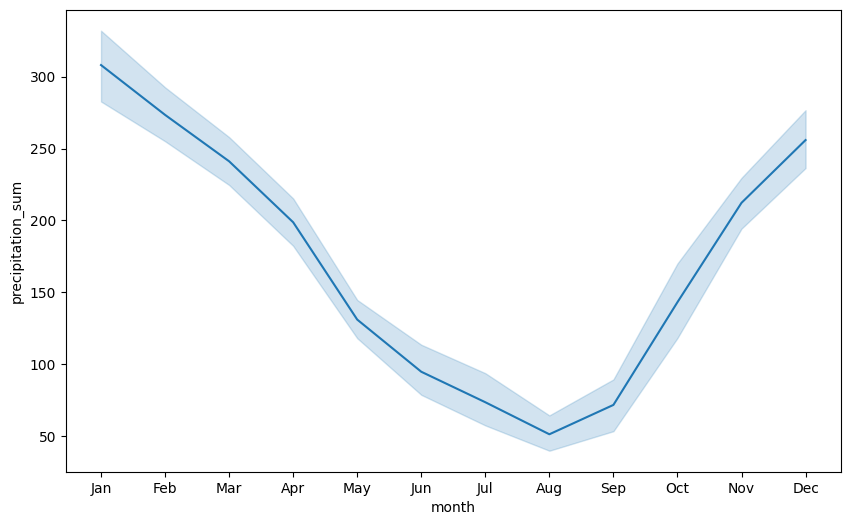

In [24]:
plt.figure(figsize=(10,6))
sns.lineplot(monthly_raw_df_seasonal, x='month', y='precipitation_sum')

In [25]:
# Convert month to a categorical type with the correct order
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
monthly_raw_df_seasonal['month'] = pd.Categorical(monthly_raw_df_seasonal['month'], categories=months, ordered=True)

# Calculate mean and standard deviation (or other desired metrics)
monthly_mean = monthly_raw_df_seasonal.groupby('month')['precipitation_sum'].mean().reset_index()
monthly_std = monthly_raw_df_seasonal.groupby('month')['precipitation_sum'].std().reset_index()

# Merge mean and std deviation data
monthly_stats = pd.merge(monthly_mean, monthly_std, on='month', suffixes=('_mean', '_std'))

# Sort the data by month
monthly_stats = monthly_stats.sort_values('month')

# Plotting with Plotly
fig = go.Figure([
    go.Scatter(
        name='Actual Monthly Precipitation',
        x=monthly_stats['month'],
        y=monthly_stats['precipitation_sum_mean'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
        showlegend=False
    ),
    go.Scatter(
        name='Upper Bound',
        x=monthly_stats['month'],
        y=monthly_stats['precipitation_sum_mean'] + monthly_stats['precipitation_sum_std'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=monthly_stats['month'],
        y=monthly_stats['precipitation_sum_mean'] - monthly_stats['precipitation_sum_std'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])

fig.update_layout(
    yaxis_title='Precipitation (mm)',
    xaxis_title='Month',
    title='Monthly Precipitation in Jakarta with Confidence Intervals',
    hovermode="x",
    height=600,
    width=1000,
    title_x=0.5
)
fig.show()

C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_33640\2683030672.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_33640\2683030672.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Distribution of Monthly Precipitation Comparison: 1980-2009 vs. 2010-2023

C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_33640\491891205.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_33640\491891205.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



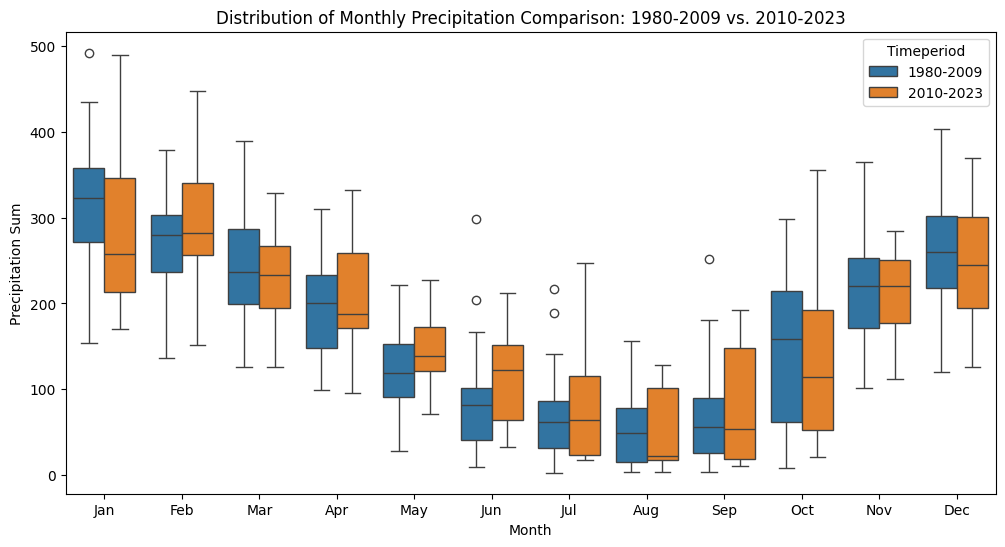

In [26]:
# Filter the data for the two periods
period_1_df = monthly_raw_df_seasonal[(monthly_raw_df_seasonal['year'] >= 1980) & (monthly_raw_df_seasonal['year'] <= 2009)]
period_2_df = monthly_raw_df_seasonal[(monthly_raw_df_seasonal['year'] >= 2010) & (monthly_raw_df_seasonal['year'] <= 2023)]

# Add a 'Timeperiod' column
period_1_df['Timeperiod'] = '1980-2009'
period_2_df['Timeperiod'] = '2010-2023'

# Combine the two DataFrames
combined_df = pd.concat([period_1_df, period_2_df])

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x="month", y="precipitation_sum", hue="Timeperiod")
plt.title('Distribution of Monthly Precipitation Comparison: 1980-2009 vs. 2010-2023')
plt.xlabel('Month')
plt.ylabel('Precipitation Sum')
plt.legend(title='Timeperiod')
plt.show()

In [27]:
# Create the box plot using Plotly
fig = px.box(combined_df, x='month', y='precipitation_sum', color='Timeperiod', 
             title='Distribution of Monthly Precipitation Comparison: 1980-2009 vs. 2010-2023', 
             labels={'month': 'Month', 'precipitation_sum': 'Precipitation Sum (mm)'})

fig.update_layout(
    yaxis_title='Precipitation (mm)',
    xaxis_title='Month',
    title_x=0.5,
    height=600,
    width=1000
)

fig.show()

## Monthly Precipitation by Year

In [52]:
# Create the plot
fig = px.line(
    monthly_raw_df_seasonal, 
    x='month', 
    y='precipitation_sum',
    color='year', 
    # symbol='year', 
    title='Monthly Precipitation by Year'
)

# Update layout for figure size
fig.update_layout(
    width=1000, height=600, title_x=0.5,
    yaxis_title='Precipitation (mm)',
    xaxis_title='Month'
)

# Set the line width
fig.update_traces(line=dict(width=0.5)) 

# Add annotations for each year's end of line
for year in monthly_raw_df_seasonal['year'].unique():
    # Get the last data point for each year
    df_year = monthly_raw_df_seasonal[monthly_raw_df_seasonal['year'] == year]
    last_month = df_year['month'].iloc[-1]
    last_precipitation_sum = df_year['precipitation_sum'].iloc[-1]
    
    # Add annotation
    fig.add_annotation(
        x=last_month,
        y=last_precipitation_sum,
        text=str(year),
        showarrow=False,
        xanchor='left',
    )

# Show plot
fig.show()

## Distribution of Monthly Precipitation by Year

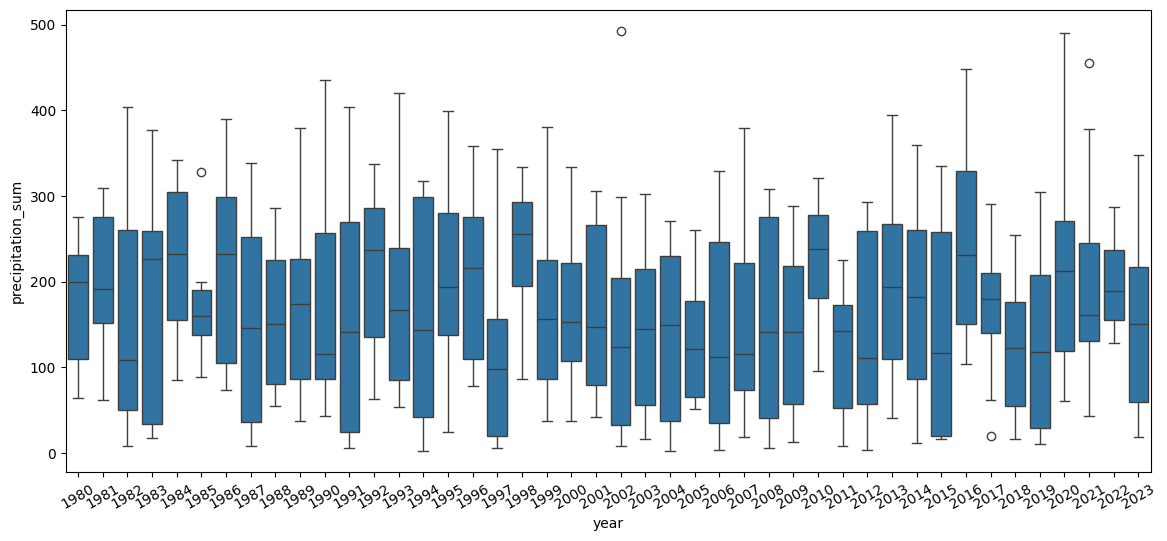

In [29]:
plt.figure(figsize=(14,6))
sns.boxplot(data=monthly_raw_df_seasonal, x="year", y="precipitation_sum")
plt.xticks(rotation=30)
plt.show()

## Yearly Precipitation by Month

In [54]:
# Create the plot
fig = px.line(monthly_raw_df_seasonal, x='year', y='precipitation_sum', color='month', symbol='month', title='Yearly Precipitation by Month')

# Update layout for figure size
fig.update_layout(
    width=1000, height=600,
    yaxis_title='Precipitation (mm)',
    xaxis_title='Month',
    title_x=0.5
)

# Add annotations for each month's end of line
for month in monthly_raw_df_seasonal['month'].unique():
    # Get the last data point for each month
    df_month = monthly_raw_df_seasonal[monthly_raw_df_seasonal['month'] == month]
    last_month = df_month['year'].iloc[-1]
    last_precipitation_sum = df_month['precipitation_sum'].iloc[-1]
    
    # Add annotation
    fig.add_annotation(
        x=last_month,
        y=last_precipitation_sum,
        text=str(month),
        showarrow=False,
        xanchor='left'
    )

# Show plot
fig.show()

## Yearly Trend of Monthly Precipitation

<Axes: xlabel='year', ylabel='precipitation_sum'>

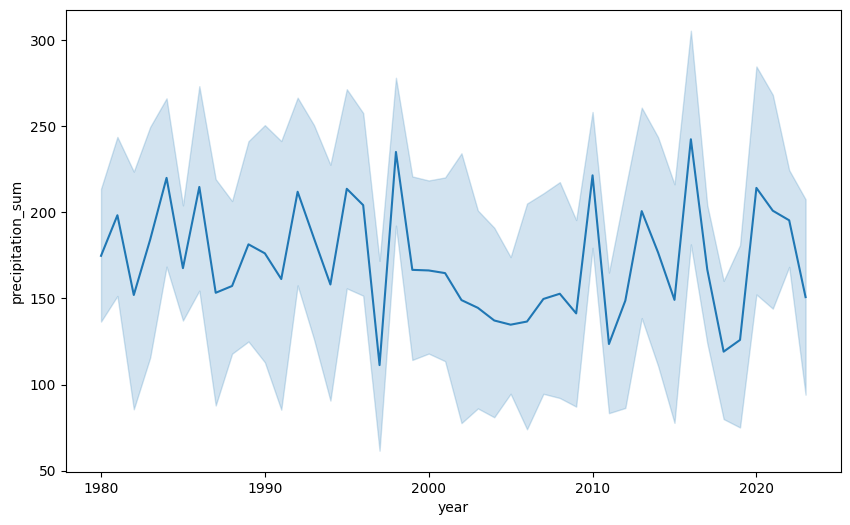

In [31]:
plt.figure(figsize=(10,6))
sns.lineplot(data=monthly_raw_df_seasonal, x="year", y="precipitation_sum")

## Check Trend and Seasonality on Monthly Data
### Check Trend

In [32]:
kendall_tau_res = check_trend(monthly_raw_df_seasonal['precipitation_sum'], confidence=0.05)
mann_kendall_res = check_trend(monthly_raw_df_seasonal['precipitation_sum'], confidence=0.05, mann_kendall=True)
mann_kendall_seas_res = check_trend(monthly_raw_df_seasonal['precipitation_sum'], confidence=0.05, mann_kendall=True, seasonal_period=None)
print(f"Kendalls Tau: Trend: {kendall_tau_res.trend} | Direction: {kendall_tau_res.direction} | Deterministic: {kendall_tau_res.deterministic}")
print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} | Deterministic: {mann_kendall_res.deterministic}")
print(f"Mann-Kendalls Seasonal: Trend: {mann_kendall_seas_res.trend} | Direction: {mann_kendall_seas_res.direction} | Deterministic: {mann_kendall_seas_res.deterministic}")

Kendalls Tau: Trend: False | Direction: decreasing | Deterministic: False
Mann-Kendalls: Trend: False | Direction: decreasing | Deterministic: False
Mann-Kendalls Seasonal: Trend: False | Direction: decreasing | Deterministic: False


### Check Seasonality

In [33]:
seasonality_res = check_seasonality(monthly_raw_df_seasonal['precipitation_sum'], max_lag=14, seasonal_period=12, confidence=0.05)
print(f"Seasonality Test for 12th lag using monthly data: {seasonality_res.seasonal}")

Seasonality Test for 12th lag using monthly data: True


## Number of Dry Days by Month

In [34]:
monthly_dry_days = daily_raw_df[daily_raw_df["precipitation_sum"] == 0][["year", "month", "precipitation_sum"]].groupby(["year", "month"]).count().reset_index()
monthly_dry_days.rename(columns={"precipitation_sum":"dry_days"}, inplace=True)
monthly_dry_days

year      month  dry_days
0    1980      April         1
1    1980     August         8
2    1980       July         4
3    1980       June         8
4    1980      March         3
..    ...        ...       ...
324  2023       July         7
325  2023       June         1
326  2023        May         1
327  2023    October         4
328  2023  September        12

[329 rows x 3 columns]

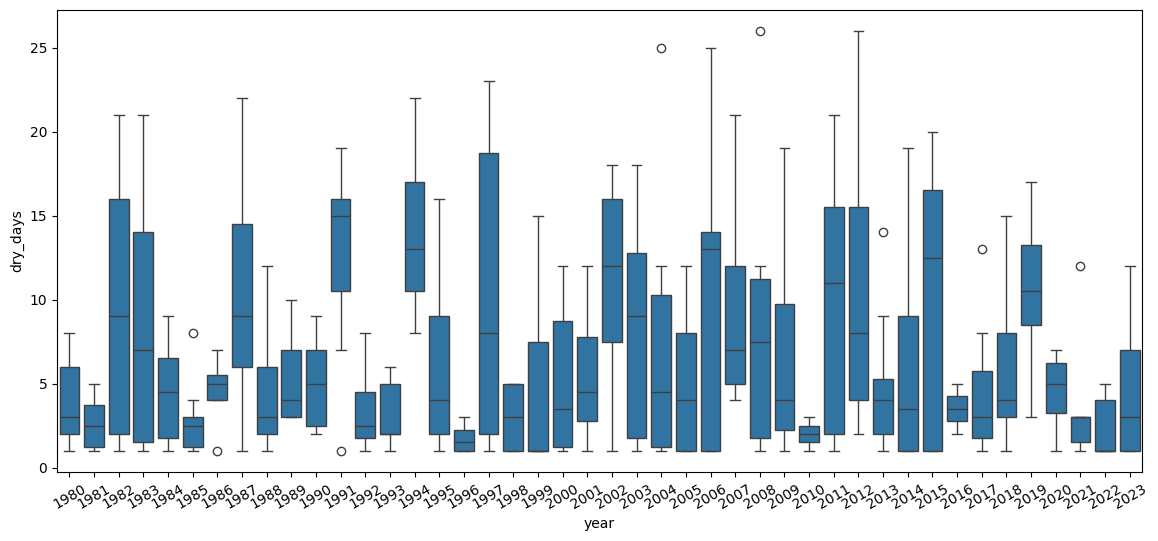

In [35]:
plt.figure(figsize=(14,6))
sns.boxplot(data=monthly_dry_days, x="year", y="dry_days")
plt.xticks(rotation=30)
plt.show()

<Axes: xlabel='year', ylabel='dry_days'>

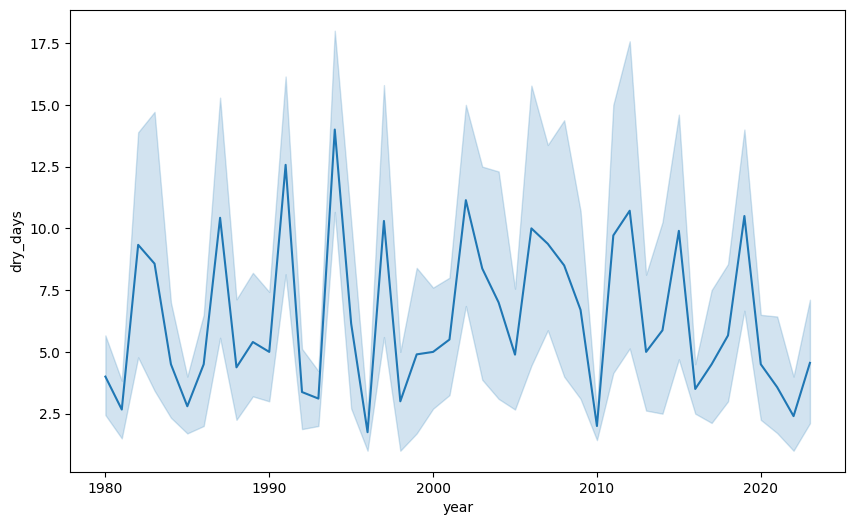

In [36]:
plt.figure(figsize=(10,6))
sns.lineplot(data=monthly_dry_days, x="year", y="dry_days")

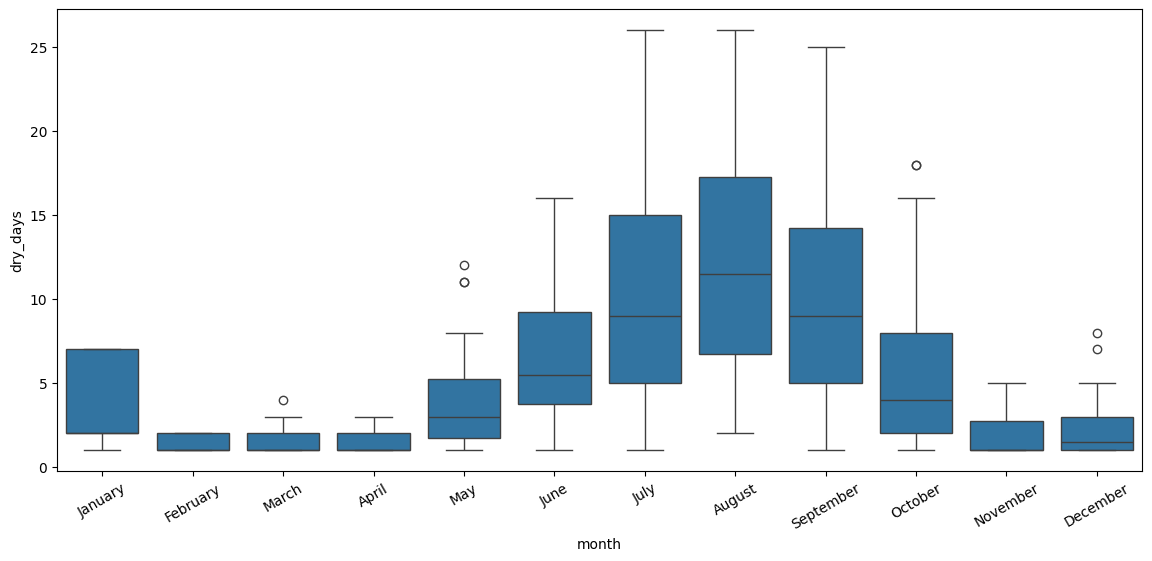

In [37]:
# Convert month to a categorical type with the correct order
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
monthly_dry_days['month'] = pd.Categorical(monthly_dry_days['month'], categories=months, ordered=True)

plt.figure(figsize=(14,6))
sns.boxplot(data=monthly_dry_days, x="month", y="dry_days")
plt.xticks(rotation=30)
plt.show()

# Yearly Data

In [38]:
yearly_raw_df = daily_raw_df[["datetime", "precipitation_sum"]].copy().set_index("datetime").resample('YE').sum()
yearly_raw_df.head()

precipitation_sum
datetime                                    
1980-12-31 00:00:00+07:00        2096.300007
1981-12-31 00:00:00+07:00        2378.699995
1982-12-31 00:00:00+07:00        1823.599995
1983-12-31 00:00:00+07:00        2209.100009
1984-12-31 00:00:00+07:00        2639.000021

## Annual Precipitation over Time

In [51]:
# Calculate the moving average (e.g., 5-year window)
yearly_raw_df['moving_average'] = yearly_raw_df['precipitation_sum'].rolling(window=5).mean()

# Calculate the overall average precipitation sum
overall_average = yearly_raw_df['precipitation_sum'].mean()

# Calculate the highest and lowest precipitation sum per year
yearly_max = yearly_raw_df['precipitation_sum'].max()
yearly_min = yearly_raw_df['precipitation_sum'].min()

# Create a smooth line using LOWESS
lowess = sm.nonparametric.lowess
smoothed = lowess(yearly_raw_df['precipitation_sum'], yearly_raw_df.index.map(pd.Timestamp.toordinal), frac=0.1)
yearly_raw_df['smoothed'] = smoothed[:, 1]

# Create figure
fig = go.Figure()

# Add the original precipitation sum time series with symbols
fig.add_trace(go.Scatter(
    x=yearly_raw_df.index, y=yearly_raw_df['precipitation_sum'],
    mode='lines+markers', name='Annual Precipitation',
    line=dict(color='royalblue'), marker=dict(color='royalblue')
))

# Add the moving average line
fig.add_trace(go.Scatter(
    x=yearly_raw_df.index, y=yearly_raw_df['moving_average'],
    mode='lines', name='5-Year Moving Average',
    line=dict(color='orange')
))

# Add the overall average line
fig.add_trace(go.Scatter(
    x=yearly_raw_df.index, y=[overall_average] * len(yearly_raw_df),
    mode='lines', name='Overall Average',
    line=dict(dash='dash', color='green')
))

# Add the highest precipitation line
fig.add_trace(go.Scatter(
    x=yearly_raw_df.index, y=[yearly_max] * len(yearly_raw_df),
    mode='lines', name='Highest Annual Precipitation',
    line=dict(dash='dash', color='red')
))

# Add the lowest precipitation line
fig.add_trace(go.Scatter(
    x=yearly_raw_df.index, y=[yearly_min] * len(yearly_raw_df),
    mode='lines', name='Lowest Annual Precipitation',
    line=dict(dash='dash', color='purple')
))

# Add the smoothed line using LOWESS as the trend line
fig.add_trace(go.Scatter(
    x=yearly_raw_df.index, y=yearly_raw_df['smoothed'],
    mode='lines', name='Yearly Smoothed Line',
    line=dict(color='black')
))

# Update layout
fig.update_layout(
    title='Annual Precipitation over Time',
    xaxis_title='Date',
    yaxis_title='Precipitation (mm)',
    height=600,
    width=1000,
    title_x=0.5,
    plot_bgcolor='white'
)

# Add range slider
fig.update_xaxes(rangeslider_visible=True)

# Show the figure
fig.show()

# Stationary Test (ADF and KPSS Test)

In [40]:
def unitroot_test_results(output, test='adf'):
    
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
            
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
       
    return pd.Series(output_dict, name=test)

In [41]:
adf_price_output = adfuller(daily_raw_df.set_index("date")["precipitation_sum"])
kpss_price_output = kpss(daily_raw_df.set_index("date")["precipitation_sum"])

pd.concat([
    unitroot_test_results(adf_price_output, 'adf'),
    unitroot_test_results(kpss_price_output, 'kpss')
], axis=1)

C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_33640\404094896.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




adf        kpss
Test Statistic         -11.878616    0.155546
p-value                       0.0         0.1
Numbers of lags                28          64
decision               Stationary  Stationary
Critical Value (1%)     -3.430758       0.739
Critical Value (5%)      -2.86172       0.463
Critical Value (10%)    -2.566866       0.347
Critical Value (2.5%)         NaN       0.574

# Correlation
## Heatmap Correlation

In [42]:
df_corr = daily_raw_df.drop(["datetime", "date", "weather_code", "weather_description", "month", "sunrise", "sunset", "snowfall_sum", "rain_sum"], axis=1)
df_corr.head()

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
0              28.846              24.046            25.854330   
1              27.346              24.046            25.212667   
2              28.146              23.346            25.237665   
3              28.546              22.696            25.487669   
4              28.946              22.896            25.787668   

   apparent_temperature_max  apparent_temperature_min  \
0                 34.134132                 27.530203   
1                 31.262905                 27.693266   
2                 32.756325                 27.296764   
3                 34.630340                 26.811935   
4                 35.127403                 26.726374   

   apparent_temperature_mean  daylight_duration  sunshine_duration  \
0                  29.699210          44900.156          33576.977   
1                  29.115060          44895.168          22360.742   
2                  29.595587          44889.720          27455.455   
3                  30.100534          44883.800          38627.418   
4                  29.990640          44877.360          42273.070   

   precipitation_sum  precipitation_hours  wind_speed_10m_max  \
0           6.300000                  5.0           15.256526   
1           9.600000                 16.0           14.003029   
2          10.900001                 15.0           11.525623   
3           8.100000                 17.0           12.229406   
4           8.999999                  4.0           14.044615   

   wind_gusts_10m_max  wind_direction_10m_dominant  shortwave_radiation_sum  \
0           33.480000                    260.03410                    18.66   
1           37.079998                    266.72708                    12.93   
2           33.839996                    278.27810                    14.33   
3           30.960001                    279.43768                    19.64   
4           30.239998                    255.09644                    19.50   

   et0_fao_evapotranspiration  year  moving_average  date_numeric  
0                    3.813442  1980             NaN        722815  
1                    2.658539  1980             NaN        722816  
2                    2.928866  1980             NaN        722817  
3                    3.852669  1980             NaN        722818  
4                    3.950702  1980             NaN        722819

<Axes: >

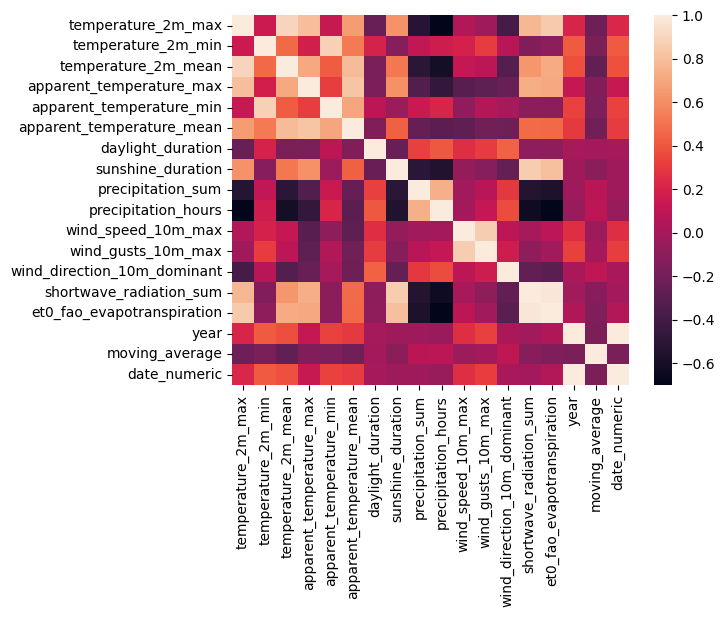

In [43]:
sns.heatmap(df_corr.corr())

In [44]:
df_corr.corr()["precipitation_sum"].sort_values(ascending=False)

precipitation_sum              1.000000
precipitation_hours            0.737111
daylight_duration              0.324455
wind_direction_10m_dominant    0.292226
apparent_temperature_min       0.142304
temperature_2m_min             0.109367
moving_average                 0.080082
wind_gusts_10m_max             0.072480
wind_speed_10m_max            -0.019668
year                          -0.022773
date_numeric                  -0.026400
apparent_temperature_mean     -0.251407
apparent_temperature_max      -0.336953
temperature_2m_mean           -0.503495
sunshine_duration             -0.509599
temperature_2m_max            -0.530916
shortwave_radiation_sum       -0.534802
et0_fao_evapotranspiration    -0.568281
Name: precipitation_sum, dtype: float64

## Autocorrelation and PACF plots

<Figure size 1000x600 with 0 Axes>

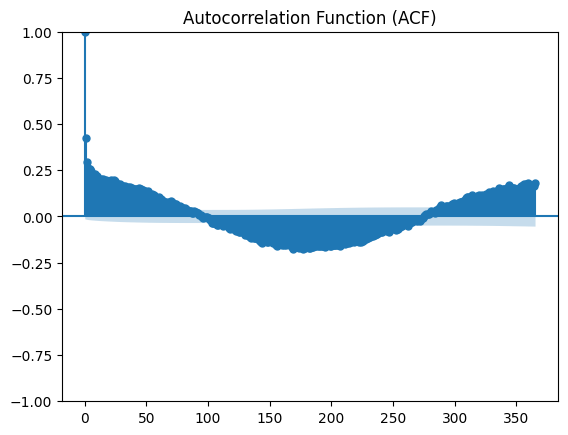

<Figure size 1000x600 with 0 Axes>

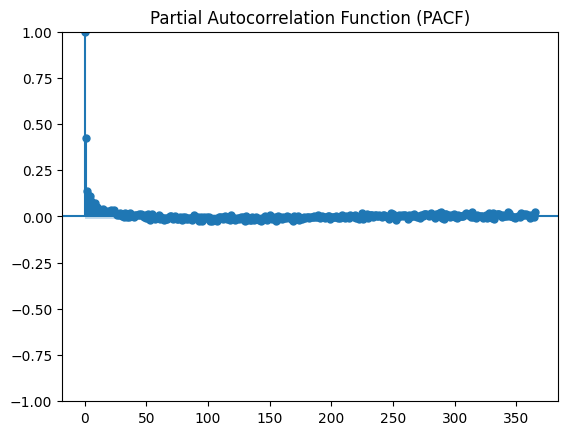

In [45]:
# Plot ACF
plt.figure(figsize=(10, 6))
plot_acf(daily_raw_df.set_index("date")["precipitation_sum"], lags=365)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(10, 6))
plot_pacf(daily_raw_df.set_index("date")["precipitation_sum"], lags=365)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

## Time Series Cross Correlation (TSCC)

In [46]:
from scipy import signal

In [47]:
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c

def ccf_plot(ccf, column1, column2, daily_raw_df):
    lags = signal.correlation_lags(len(daily_raw_df[column1]), len(daily_raw_df[column2]))

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x=0, color='black', lw=1)
    ax.axhline(y=0, color='black', lw=1)
    ax.axhline(y=np.max(ccf), color='blue', lw=1, linestyle='--', label='highest +/- correlation')
    ax.axhline(y=np.min(ccf), color='blue', lw=1, linestyle='--')
    ax.set(ylim=[-1, 1])
    ax.set_title(f'Cross Correlation {column1} and {column2}', weight='bold', fontsize=12)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize=12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize=12)
    plt.legend()
    plt.show()

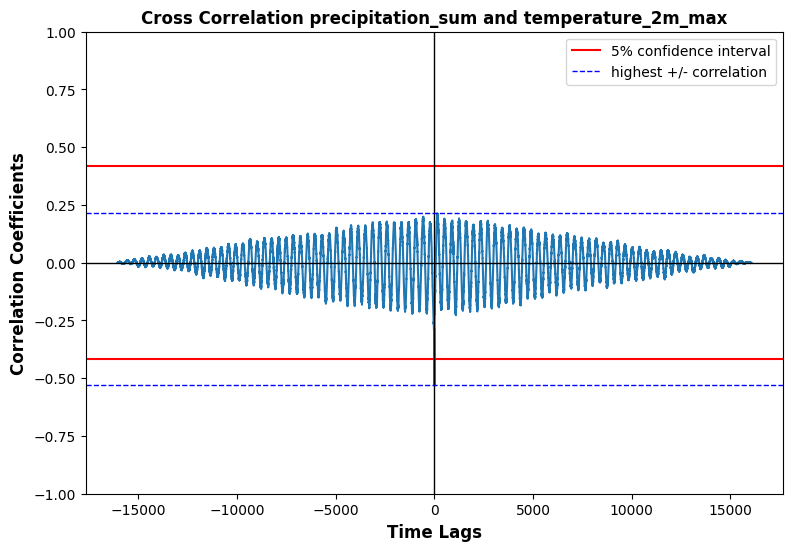

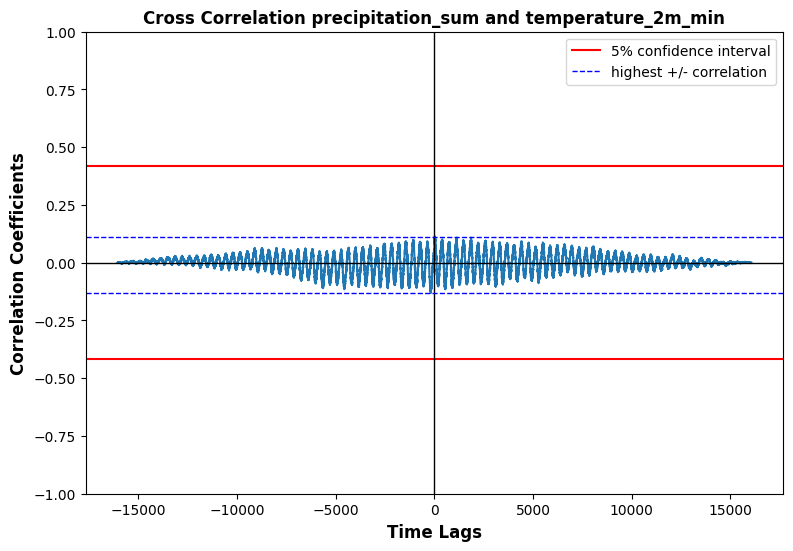

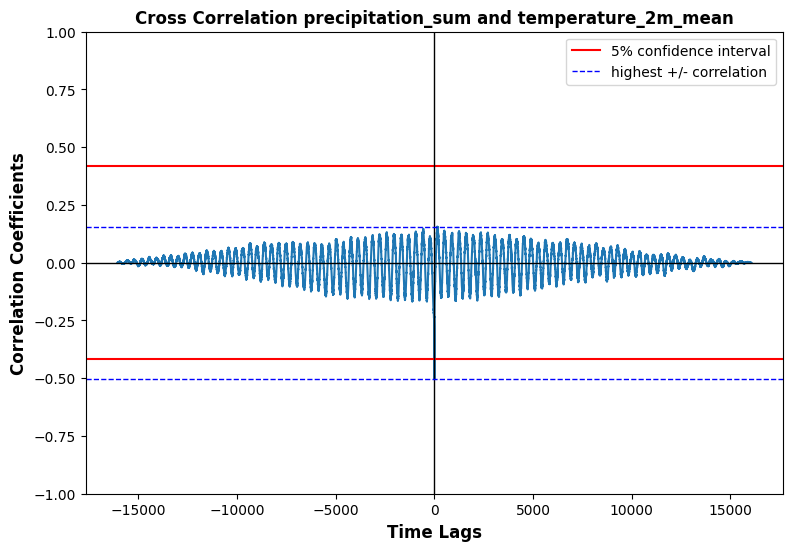

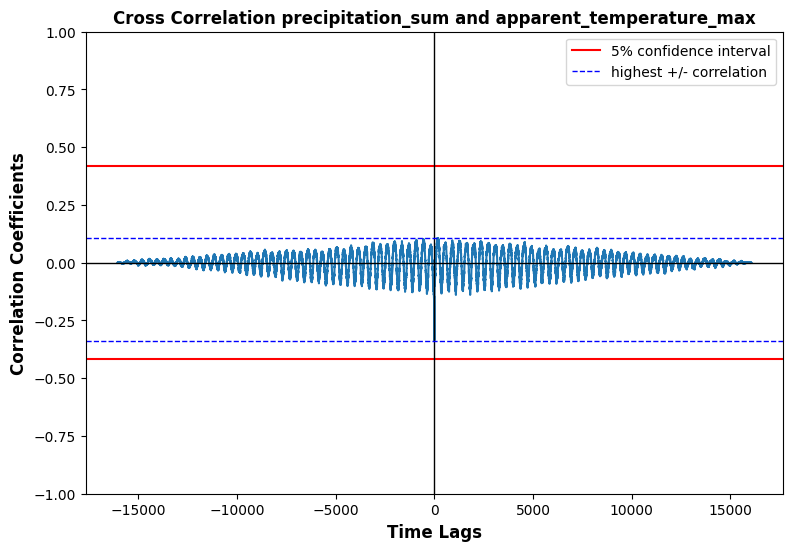

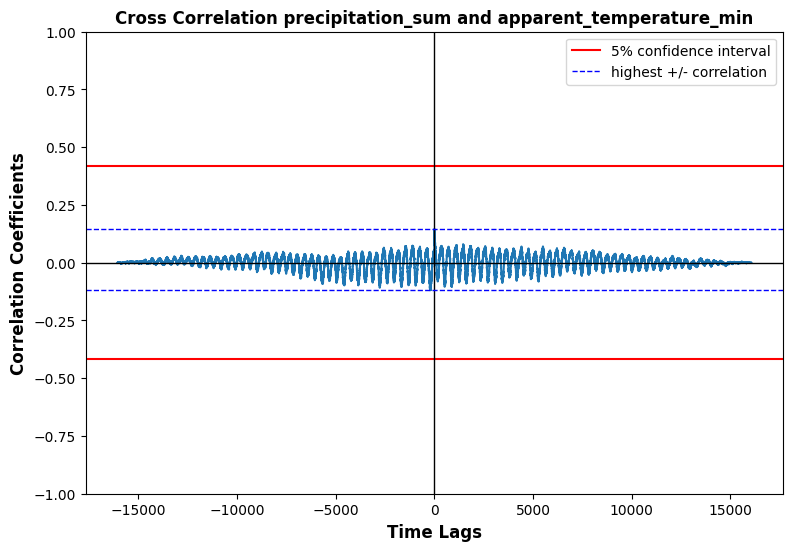

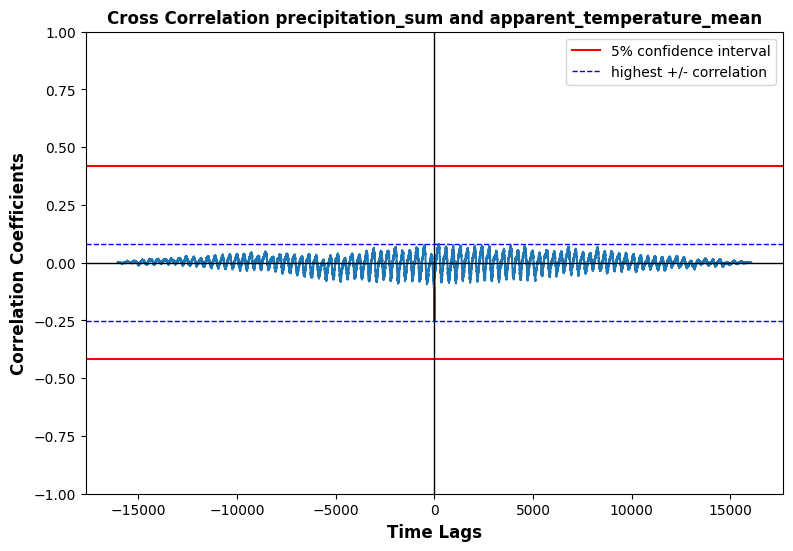

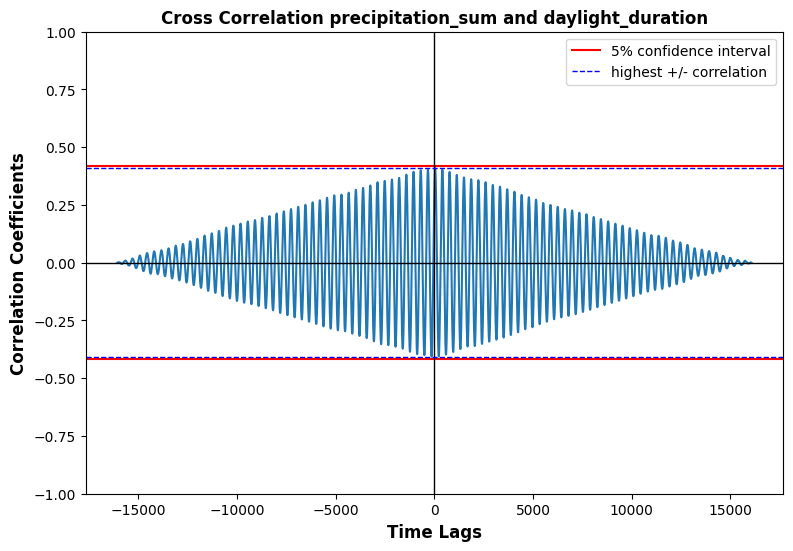

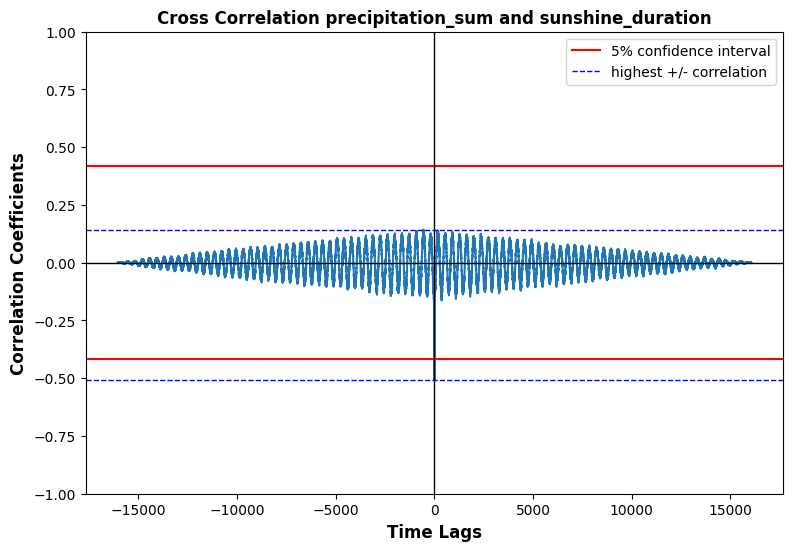

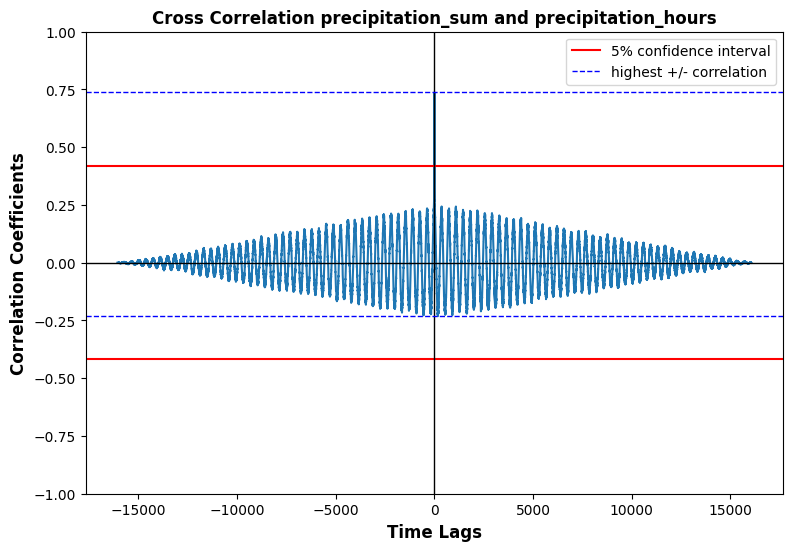

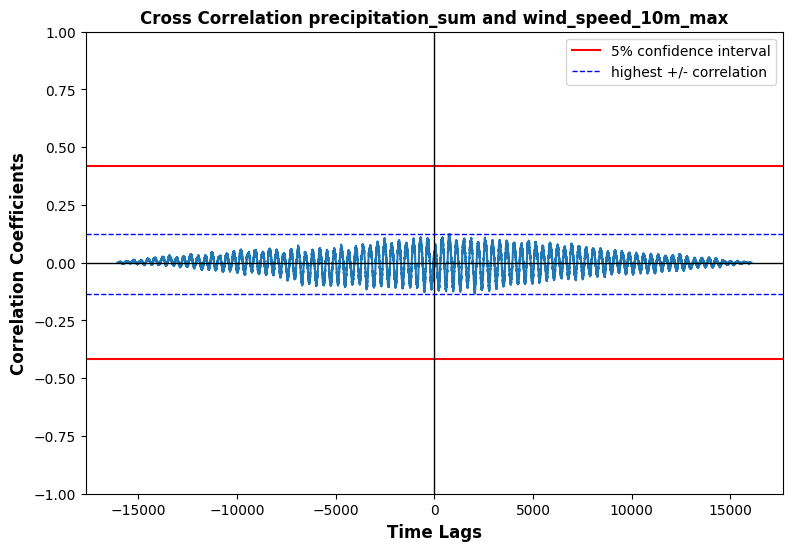

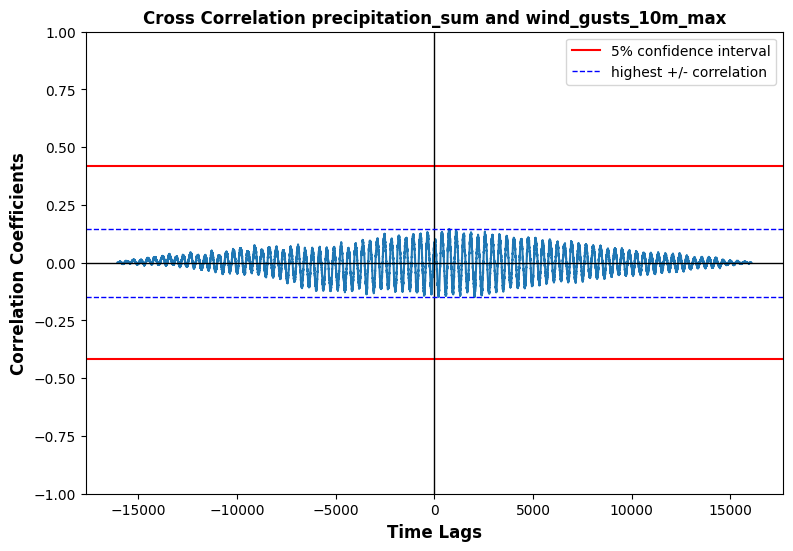

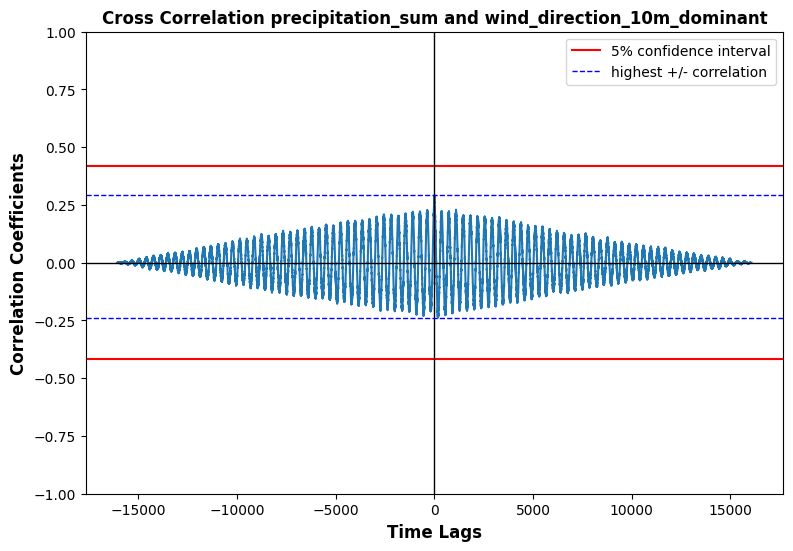

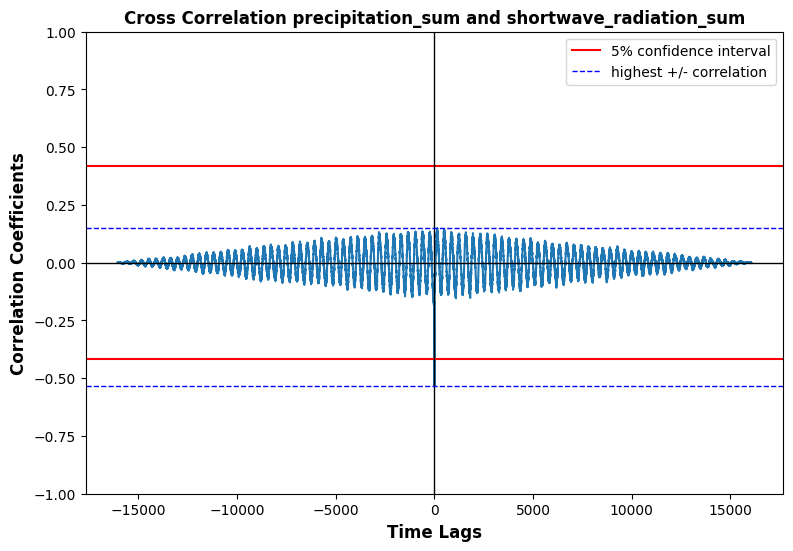

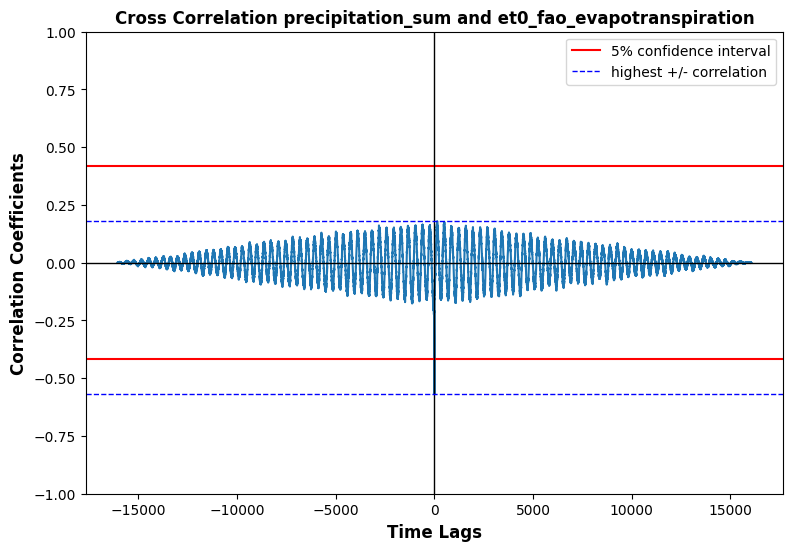

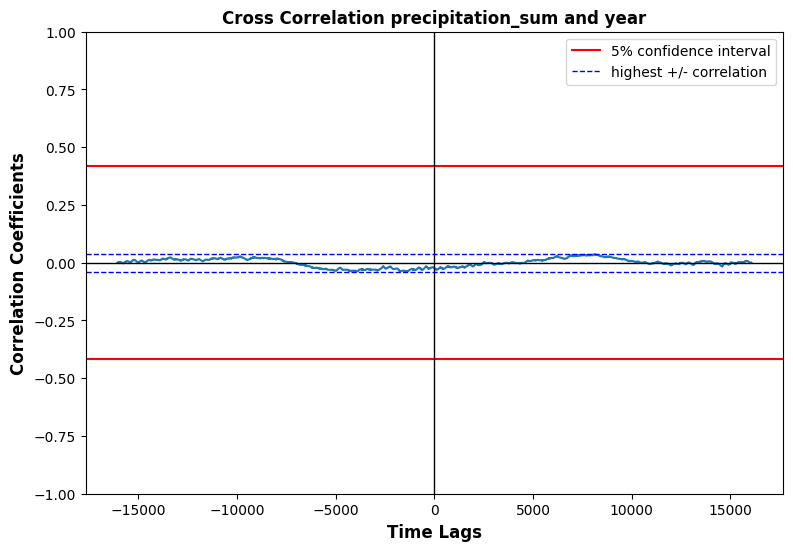

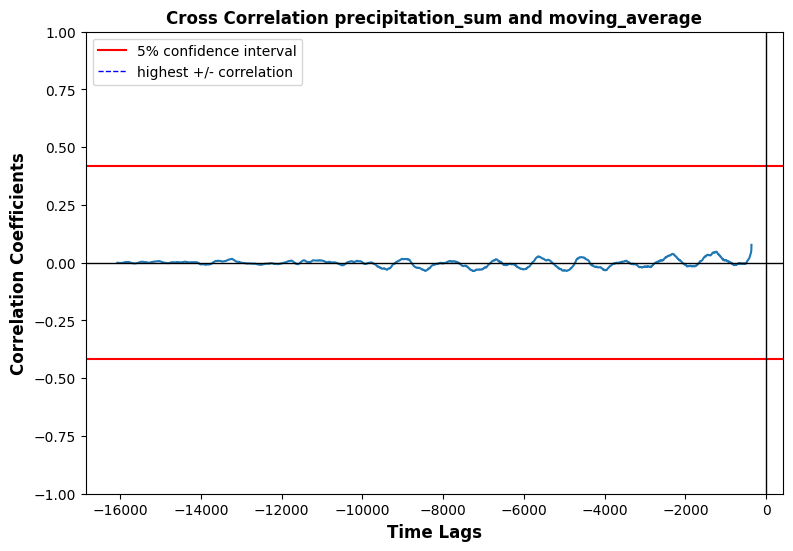

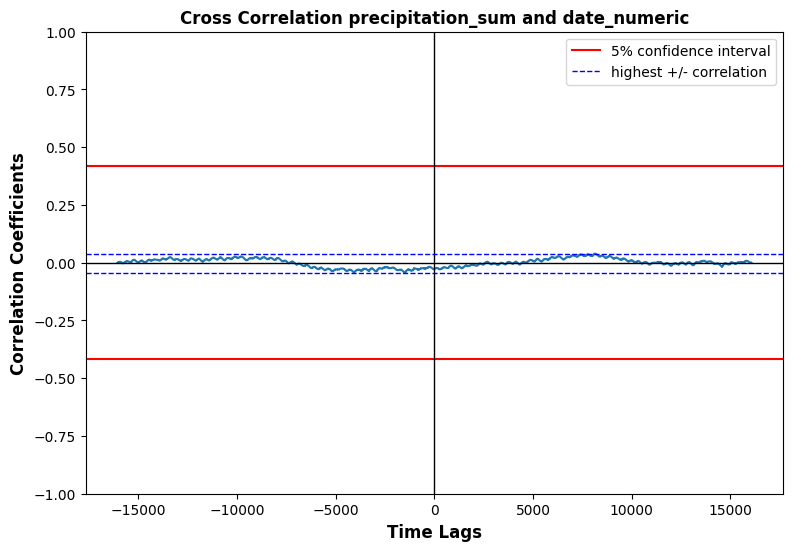

In [48]:

# List of columns to compute cross-correlation against 'precipitation_sum'
columns_to_compare = df_corr.columns.drop('precipitation_sum')

for col in columns_to_compare:
    ccf = ccf_values(df_corr['precipitation_sum'], df_corr[col])
    ccf_plot(ccf, 'precipitation_sum', col, df_corr)

# Weather Condition Distribution

In [49]:
daily_raw_df["weather_description"].unique()

yearly_weather_condition_count = daily_raw_df.groupby(["year", "weather_description"])["precipitation_sum"].count().reset_index()
yearly_weather_condition_count.rename(columns={"precipitation_sum":"total_days"}, inplace=True)
yearly_weather_condition_count.head()

year weather_description  total_days
0  1980           Clear Sky           1
1  1980      Drizzle: Dense          23
2  1980      Drizzle: Light          75
3  1980   Drizzle: Moderate          54
4  1980        Mainly Clear           9

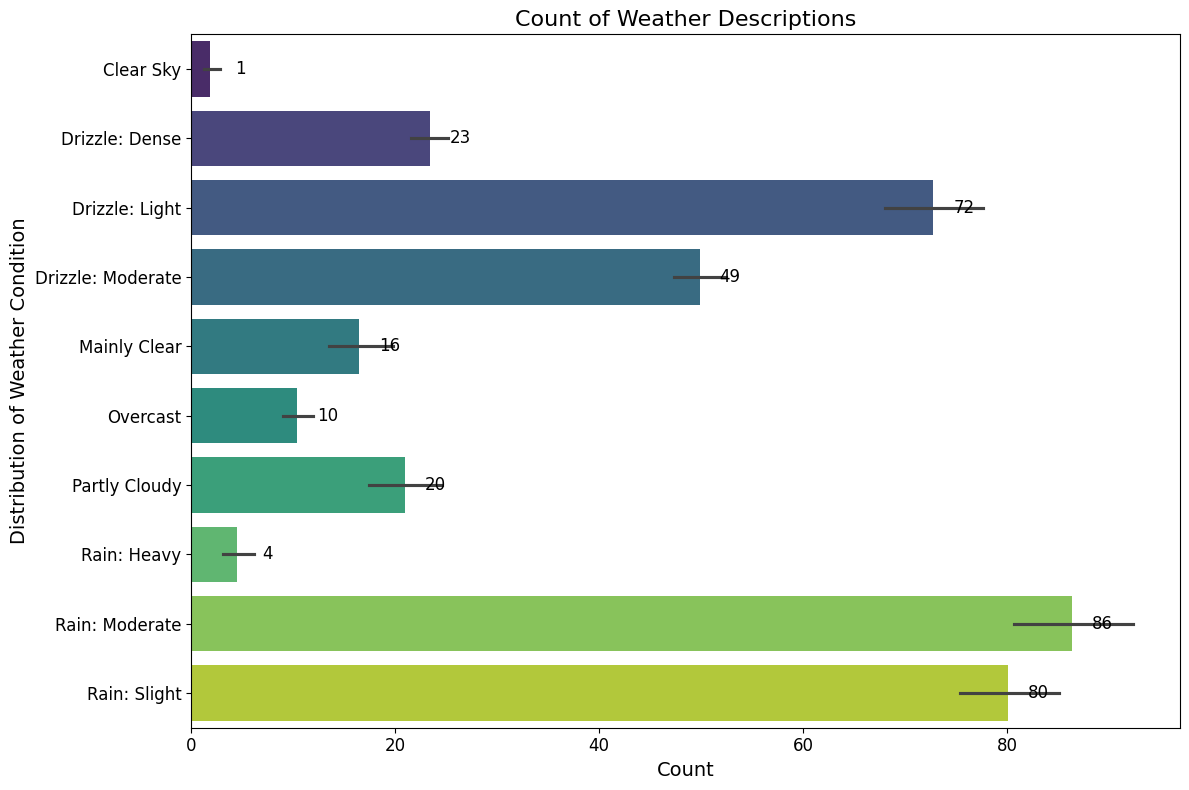

In [50]:
# Create the horizontal count plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(
                data=yearly_weather_condition_count, 
                y="weather_description", x="total_days", hue="weather_description", palette="viridis")

# Add a title and labels
ax.set_title('Count of Weather Descriptions', fontsize=16)
ax.set_xlabel('Count', fontsize=14)
ax.set_ylabel('Distribution of Weather Condition', fontsize=14)

# Customize the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Add counts on the bars
for p in ax.patches:
    width = p.get_width()  # Get the width of each bar
    ax.text(width + 3,     # Set the text position
            p.get_y() + p.get_height() / 2,  # Position in the middle of the bar
            f'{int(width)}',  # Display the count
            ha='center', va='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()